<a href="https://www.kaggle.com/code/zeeshanahmadyar/titanic-dataset-model-evaluation-metrics?scriptVersionId=294338875" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **📌 Notebook Introduction**
***🚢 Titanic Dataset – Model Evaluation Metrics***

The Titanic dataset is one of the most popular datasets for learning **machine learning fundamentals**.
In this notebook, the main focus is not only on **building** a model, but on understanding how to **evaluate** a model properly using different **evaluation metrics.**

Many beginners train a model and only check **accuracy**. However, accuracy alone is not enough to judge a model’s real performance, especially when data is **imbalanced**.

In this notebook, I will:
* Train a classification model
* Evaluate it using multiple metrics
* Explain why each metric matters

The goal is to build clear intuition about model evaluation in a simple and practical way.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic-dataset/Titanic-Dataset.csv


In [2]:
# import dataset
df = pd.read_csv('/kaggle/input/titanic-dataset/Titanic-Dataset.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# **📊 Before Model Training**

**🔍 Understanding the Dataset:**
Before training any model, it is important to understand the data.

The **Titanic dataset** contains information about passengers such as:
* Age
* Gender
* assenger class
* Fare

The target variable is **Survived**, which makes this a binary classification problem.

Understanding the dataset helps us choose the right model and the right **evaluation metrics.**

# **Detecting and removing Outliers**

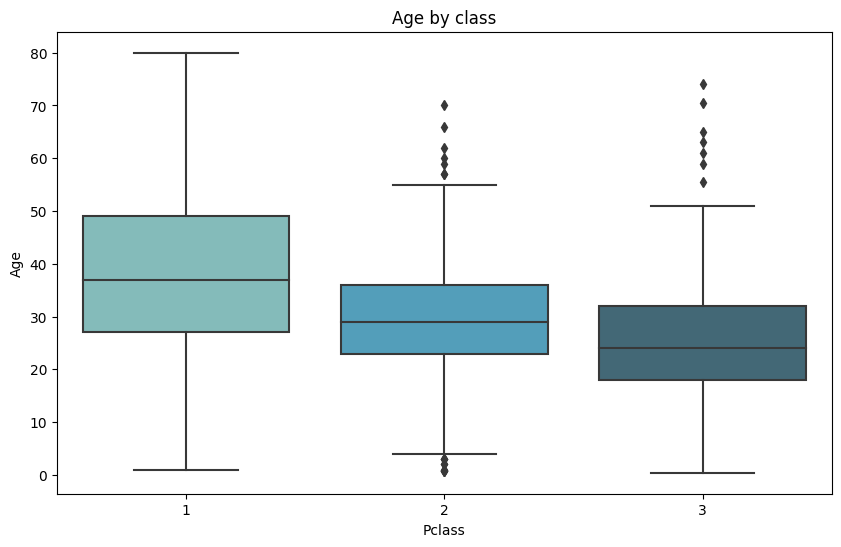

In [3]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Pclass', y='Age', data=df, palette='GnBu_d').set_title('Age by class')
plt.show()

<Axes: >

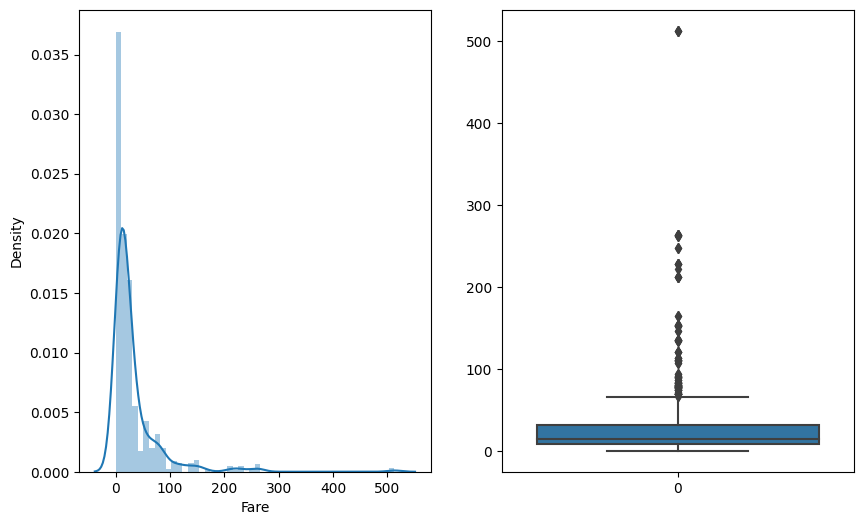

In [4]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
sns.distplot(df['Fare'])

plt.subplot(1, 2, 2)
sns.boxplot(df['Fare'])

# **Remove Outliers using Persontile**

In [5]:
upper_limit = df['Age'].quantile(0.99)
lower_limit = df['Age'].quantile(0.01)

In [6]:
df['Age'] = np.where(df['Age'] >= upper_limit,
                    upper_limit,
                    np.where(df['Age'] <= lower_limit,
                            lower_limit,
                            df['Age']
        )
)

In [7]:
# remove outliers in fare feature
upper_limit = df['Fare'].quantile(0.99)
lower_limit = df['Fare'].quantile(0.01)

In [8]:
df['Fare'] = np.where(df['Fare'] >= upper_limit,
                    upper_limit,
                    np.where(df['Fare'] <= lower_limit,
                            lower_limit,
                            df['Fare']
                            )
                    )

# **Fill missing Values with the mean**

In [9]:
# calculate the mean by classes
class1_mean = df[df['Pclass'] == 1]['Age'].mean()
class2_mean = df[df['Pclass'] == 2]['Age'].mean()
class3_mean = df[df['Pclass'] == 3]['Age'].mean()

def impute_age(col):
    Age = col[0]
    Pclass = col[1]

    if pd.isnull(Age):
        if Pclass == 1:
            return class1_mean
        elif Pclass == 2:
            return class2_mean
        else:
            return class3_mean
    else:
        return Age

df['Age'] = df[['Pclass', 'Age']].apply(impute_age, axis=1)

# **Now we remove columns with no or weak relation**

In [10]:
df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
df.dropna(inplace=True)
# df.head()

# **Encode categorical features**

In [11]:
df = pd.get_dummies(df, columns=['Sex', 'Embarked'], dtype=int, drop_first=True)
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
0,0,3,3.0,1,0,7.2500,1,0,1
1,1,1,1.0,1,0,71.2833,0,0,0
2,1,3,3.0,0,0,7.9250,0,0,1
3,1,1,1.0,1,0,53.1000,0,0,1
4,0,3,3.0,0,0,8.0500,1,0,1


# **Divide data into input and Target Variable**

In [12]:
X = df.drop('Survived', axis=1)
y = df['Survived']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)

# **Scaled Numerical Data**

In [14]:
# create instance for standard scaler
scaler = StandardScaler()

In [15]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# **⚙️ Model Training Section**

🤖 Model Training

After **preprocessing** the data, a **classification** model is trained to predict whether a passenger survived or not.

The main objective here is not **hyperparameter tuning**, but to create a baseline model that allows us to analyze **evaluation metrics** clearly.

Once the model is trained, we move to the most important part of this notebook — **model evaluation.**

# **LogisticRegression**
Create an instance of Model

In [16]:
Lreg = LogisticRegression()

In [17]:
Lreg.fit(X_train_scaled, y_train)

LogisticRegression()

# **📈 Evaluation Metrics Explanation**
**📐 Model Evaluation Metrics**

Instead of relying only on accuracy, this notebook evaluates the model using multiple metrics:
* Accuracy: Overall correctness of predictions
* Precision: How many predicted survivors were actually correct
* Recall: How many actual survivors were correctly identified
* F1-Score: Balance between precision and recall

Each metric highlights a different aspect of **model performance**.
This approach helps us understand where the model performs well and where it struggles.

# **Evaluate LogisticRegression Model**

In [18]:
y_pred_Lreg = Lreg.predict(X_test_scaled)

In [19]:
# Accuracy
y_pred_accuracy = round(accuracy_score(y_test, y_pred_Lreg) * 100, 2)

# find precision, recall, and confusion_matrix
precision = round(precision_score(y_test, y_pred_Lreg) * 100, 2)
recall = round(recall_score(y_test, y_pred_Lreg) * 100, 2)
confusion = confusion_matrix(y_test, y_pred_Lreg)

Accuracy: 80.34
Precision: <function precision_score at 0x7fbd676c9580>
Recall: 64.79
------------------------------
[[97 10]
 [25 46]]


<Axes: >

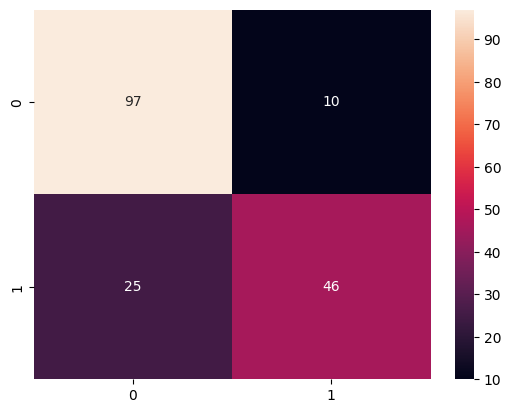

In [20]:
# print the results
print(f'Accuracy: {y_pred_accuracy}')
print(f'Precision: {precision_score}')
print(f'Recall: {recall}')
print('-' * 30)

# Confisuion Matrix
print(confusion)
sns.heatmap(confusion, annot=True, fmt='d')

# **💡 Why Evaluation Metrics Matter**
In real-world machine learning problems, choosing the wrong evaluation metric can lead to poor decisions.

**For example:**

* High accuracy does not always mean a good model
* A model with lower accuracy but higher recall may be more useful in certain cases

This notebook **demonstrates** how to think like a machine learning **practitioner**, not just how to train a model.

# **Decision Tree Model**

In [21]:
Dtree = DecisionTreeClassifier()

In [22]:
# pass training data into model
Dtree.fit(X_train_scaled, y_train)

DecisionTreeClassifier()

# **Evaluate DecisionTreeClassifier Model**

In [23]:
y_pred_Dtree = Dtree.predict(X_test_scaled)

In [24]:
# Accuracy
Dtree_accuracy = round(accuracy_score(y_test, y_pred_Dtree) * 100, 2)
Dtree_precision = round(precision_score(y_test, y_pred_Dtree) * 100, 2)
Dtree_recall = round(recall_score(y_test, y_pred_Dtree) * 100, 2)

# Comfusion Metrix
Dtree_confusion = confusion_matrix(y_test, y_pred_Dtree)

Accuracy: 78.09
Precision: 75.81
Recall: 66.2
Confusion Metrix: [[92 15]
 [24 47]]


<Axes: >

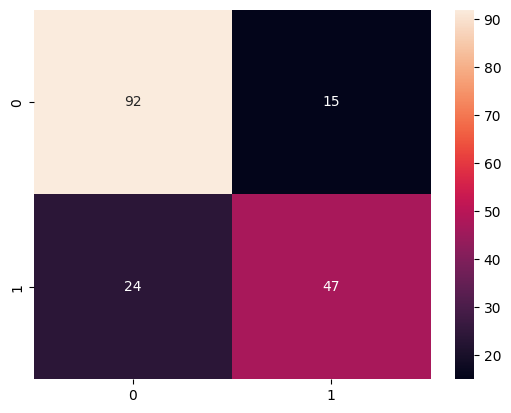

In [25]:
# print results
print('Accuracy:', Dtree_accuracy)
print('Precision:', Dtree_precision)
print('Recall:', Dtree_recall)
print('Confusion Metrix:', Dtree_confusion)

# draw graph
sns.heatmap(Dtree_confusion, annot=True, fmt='d')

# **Random Forest Model**

In [26]:
rfc = RandomForestClassifier()

In [27]:
# give data to model
rfc.fit(X_train_scaled, y_train)

RandomForestClassifier()

# **Model Evaluation RandomForestClassifier**

In [28]:
# predict model
y_pred_rfc = rfc.predict(X_test_scaled)

In [29]:
# accuracy
rfc_accuracy = round(accuracy_score(y_test, y_pred_rfc) * 100, 2)
rfc_precision = round(precision_score(y_test, y_pred_rfc) * 100, 2)
rfc_recall = round(recall_score(y_test, y_pred_rfc) * 100, 2)
rfc_confusion = confusion_matrix(y_test, y_pred_rfc)

Accuracy: 79.78
Precision: 78.69
Recall: 67.61
--------------------
Confusion Metrix: [[94 13]
 [23 48]]


<Axes: >

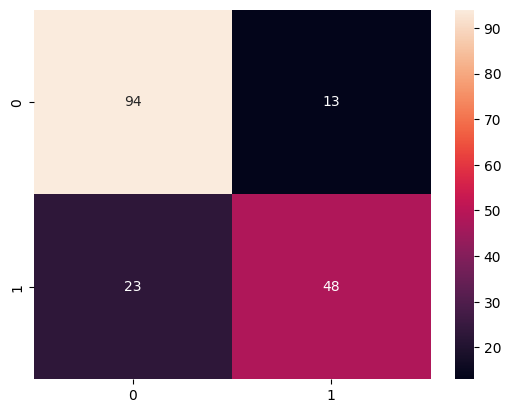

In [30]:
# print results
print('Accuracy:', rfc_accuracy)
print('Precision:', rfc_precision)
print('Recall:', rfc_recall)
print('-' * 20)
print('Confusion Metrix:', rfc_confusion)

# draw graph
sns.heatmap(rfc_confusion, annot=True, fmt='d')

# **GradientBoostingClassifier Model**

In [31]:
# create instance for model
gbc = GradientBoostingClassifier()

In [32]:
# give data to model
gbc.fit(X_train_scaled, y_train)

GradientBoostingClassifier()

# **Model Evaluation GradientBoostingClassifier**

In [33]:
y_pred_gbc = gbc.predict(X_test_scaled)

In [34]:
# accuracy
gbc_accuracy = round(accuracy_score(y_test, y_pred_gbc) * 100, 2)
gbc_precision = round(precision_score(y_test, y_pred_gbc) * 100, 2) # precision score
gbc_recall = round(recall_score(y_test, y_pred_gbc) * 100, 2)  # recall score

# Confusion Metrix
gbc_confusion = confusion_matrix(y_test, y_pred_gbc)

Accuracy: 81.46
Precision: 85.19
Recall: 64.79
--------------------
Confusion Metrix: [[99  8]
 [25 46]]


<Axes: >

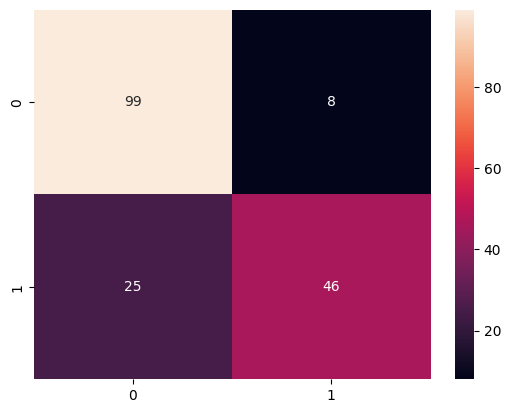

In [35]:
# print results
# print results
print('Accuracy:', gbc_accuracy)
print('Precision:', gbc_precision)
print('Recall:', gbc_recall)
print('-' * 20)
print('Confusion Metrix:', gbc_confusion)

# draw graph
sns.heatmap(gbc_confusion, annot=True, fmt='d')

# **✅ Final Conclusion**
# 🏁 Conclusion

This notebook focused on model evaluation rather than model complexity.

Key takeaways:

* Accuracy alone is not sufficient
* Different metrics serve different purposes
* A confusion matrix provides deeper insight into model behavior
* By using proper evaluation metrics, we can build more reliable and trustworthy machine learning models.

This notebook is designed to help beginners and intermediate learners develop strong evaluation intuition, which is a critical skill for any **AI/ML engineer.**

Feedback and suggestions are always welcome.
If you found this notebook useful, consider giving it an ***upvote*** ⭐